In [4]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

## Loading Data

In [5]:
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
players
sessions

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


## (1) Data Description:
### Dataset Overview

| Dataset | Description | # Observations | # Variables | Key Variable |
|----------|--------------|----------------|--------------|---------------|
| players.csv | Player demographic and skill information | 196 | 7 | hashedEmail |
| sessions.csv | Each recorded game session per player | 1535 | 5 | hashedEmail |


### players.csv — Variable Summary

| Variable | Type | Meaning |
|-----------|------|---------|
| experience | character | Player's self-reported gaming experience level (e.g., Amateur, Pro, Veteran) |
| subscribe | logical | Whether the player subscribed to the game newsletter |
| hashedEmail | character | Anonymized unique player identifier |
| played_hours | numeric | Total number of hours the player has played on the server |
| name | character | Player’s in-game name or alias |
| gender | character | Player’s gender (Male, Female, Other, or Prefer not to say) |
| Age | numeric | Player’s age in years (some missing values) |

---

### sessions.csv — Variable Summary

| Variable | Type | Meaning |
|-----------|------|---------|
| hashedEmail | character | Unique player ID (foreign key linking to players.csv) |
| start_time | character | Start time of a game session |
| end_time | character | End time of a game session |
| original_start_time | numeric | Original start time as a UNIX timestamp |
| original_end_time | numeric| Original end time as a UNIX timestamp |

---

### Potential Data Issues and Observations

| Category | Description | Possible Impact |
|-----------|--------------|----------------|
| Missing values | `Age` contains missing data; `gender` includes “Prefer not to say” | Could reduce sample size or introduce bias |
| Outliers | Some players have 0 or unusually high `played_hours` | May skew averages or affect regression results |
| Data type inconsistencies | `start_time` and `end_time` are stored as character, not datetime | Need conversion with `lubridate` for time-based calculations |
| Duplicates | Players may appear multiple times in `sessions.csv` | Must aggregate sessions per player |
| Sampling bias | Data comes from a voluntary Minecraft research server | May not represent the general player population |
| Ethical considerations | All identifiers are anonymized (`hashedEmail`) | Satisfies data privacy and ethics requirements |

---


### How the Data Were Collected

The data were collected from a Minecraft research server operated by the UBC Computer Science department.  
Player information (`players.csv`) was obtained through voluntary registration forms, including demographics, experience, and newsletter subscription.  
Session data (`sessions.csv`) were automatically logged by the server, recording start and end times for each play session.  
All players were anonymized using hashed identifiers (`hashedEmail`) to ensure privacy and comply with research ethics.


### Summary Statistics for Numeric Variables in `players.csv` （See Part 3)

| Variable     | Min | Mean  | Median | Max   | SD   |
|---------------|------|--------|---------|--------|--------|
| Age           | 9.00 | 21.14 | 19.00 | 58.00 | 7.39 |
| played_hours  | 0.00 | 5.85  | 0.10  | 223.10 | 28.36 |


## (2) Questions

### Broad Question
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

### Specific Predictive Question
Which combination of player features — such as **age**, **gender**, **experience level**, **total playtime**, and **average session duration (avg_session_min)** — best predicts whether a player will subscribe to the newsletter, and how much does each factor contribute to improving the prediction accuracy?

### How the Data Help
The `players.csv` dataset includes each player's demographic information (`Age`, `gender`), self-reported experience level (`experience`), total playtime (`played_hours`), and subscription status (`subscribe`).  
The `sessions.csv` dataset records detailed play sessions, from which we can calculate each player's **average session duration (`avg_session_min`)**.  
These combined data allow us to test how demographic and behavioural features, both individually and together, relate to subscription behaviour and which combinations produce the most accurate predictions.

### Data Wrangling Plan
- Use both `players.csv` and `sessions.csv` datasets.  
- Keep `subscribe` as the variable we aim to predict.  
- Use `Age`, `gender`, `experience`, `played_hours`, and `avg_session_min` as predictors, testing different feature combinations.  
- Handle missing values (e.g., missing `Age` or incomplete session data) and ensure all categorical variables are properly encoded.  
- Convert `experience` to a factor variable for classification.  
- Calculate `avg_session_min` from session data as:
  \[
  avg\_session\_min = \frac{end\_time - start\_time}{\text{number of sessions}}
  \]
- Split the final dataset into **training (80%)** and **testing (20%)** sets, and compare model performance to identify which feature combination best predicts subscription.


### (3) Exploratory Data Analysis and Visualization:

In [40]:
## Minimal Data Wrangling to Create Tidy Datasets

players_tidy <- players |>
  mutate(
    experience    = as.factor(experience),
    gender        = as.factor(gender))



sessions_tidy <- sessions |>
  mutate(
    start_time  = dmy_hm(start_time, quiet = TRUE),
    end_time    = dmy_hm(end_time, quiet = TRUE),
    duration_min = as.numeric(difftime(end_time, start_time, units = "mins")))

session_summary <- sessions_tidy %>%
  group_by(hashedEmail) %>%
  summarise(
    avg_session_min = mean(duration_min, na.rm = TRUE),
    session_count = n(),
    .groups = "drop"
  )

#merge with players.csv
players_extended <- left_join(players, session_summary, by = "hashedEmail")

players_extended


experience,subscribe,hashedEmail,played_hours,name,gender,Age,avg_session_min,session_count
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,74.77778,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,85.00000,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5.00000,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57,5.00000,1
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,29.83333,6
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA,15.00000,1


In [17]:
# calculating the means of Age and played_hours
mean_Age <- mean(players$Age, na.rm = TRUE)
mean_played_hours <- mean(players$played_hours, na.rm = TRUE)

mean_values <- data.frame(
  Variable = c("Age", "played_hours"),
  Mean = round(c(mean_Age, mean_played_hours), 2)
)

mean_values

Variable,Mean
<chr>,<dbl>
Age,21.14
played_hours,5.85


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


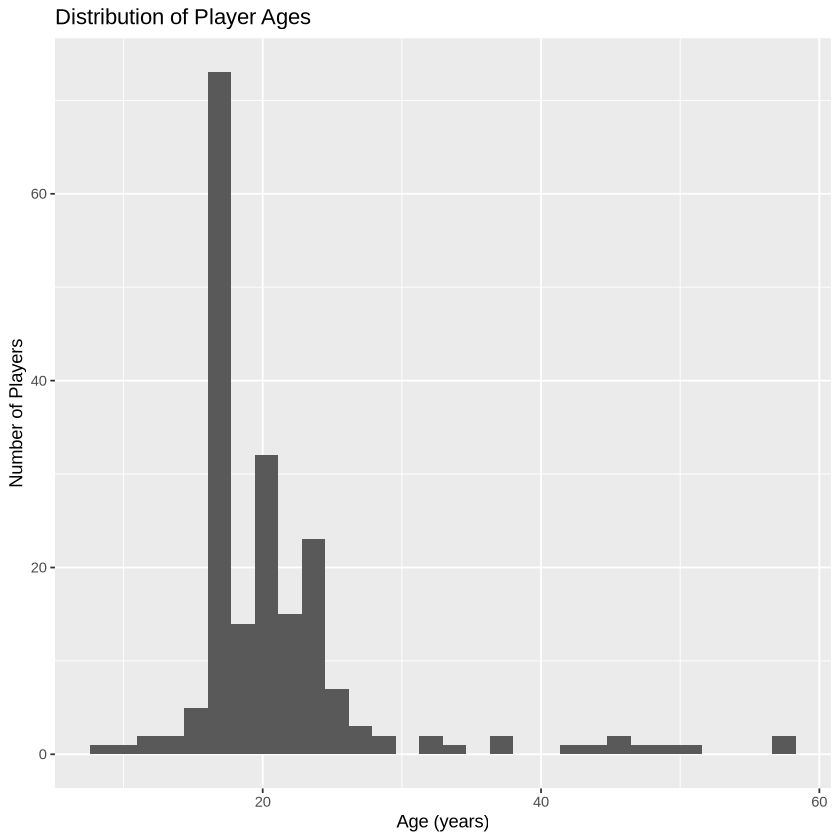

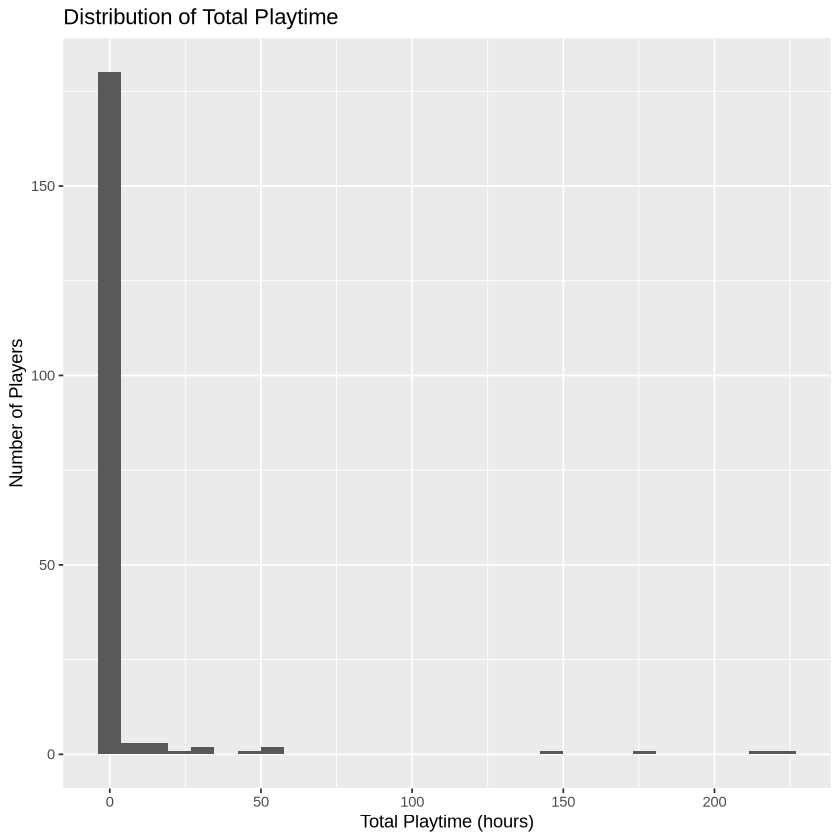

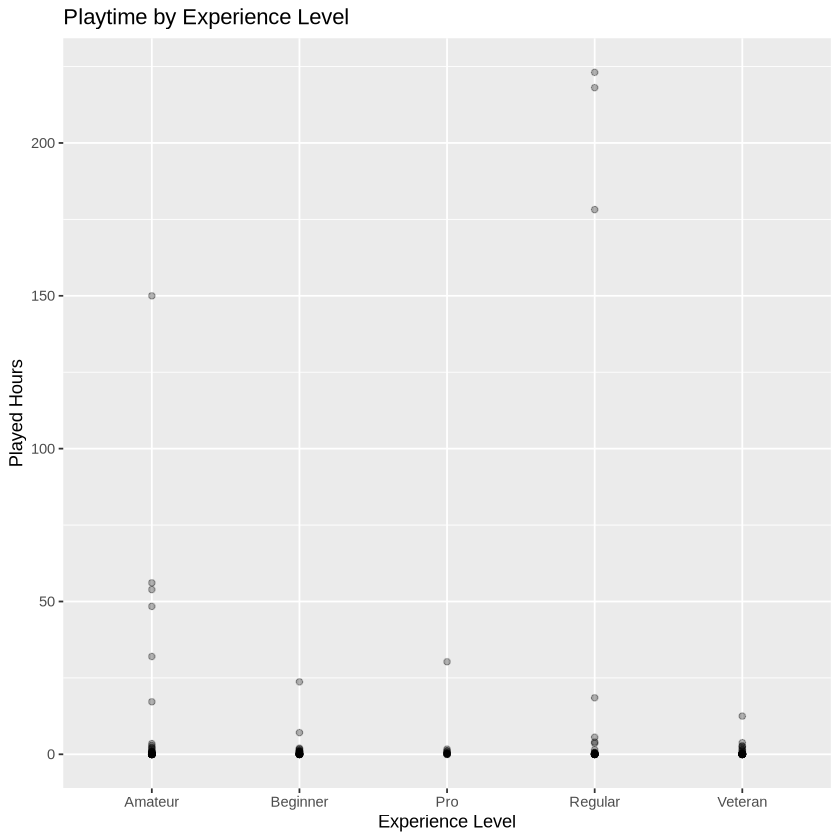

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_col()`).”


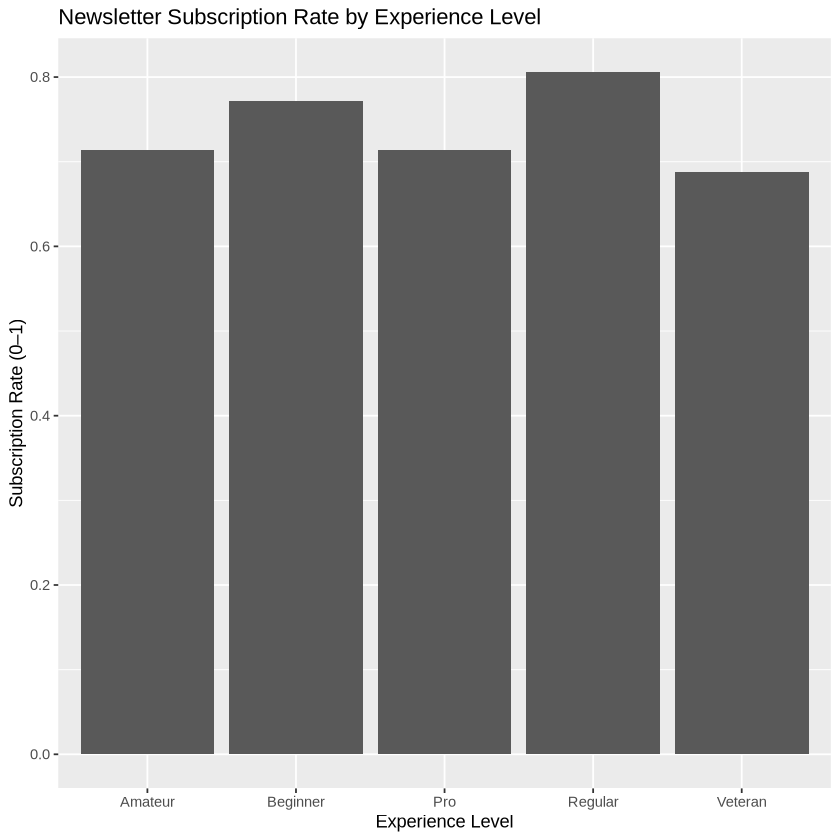

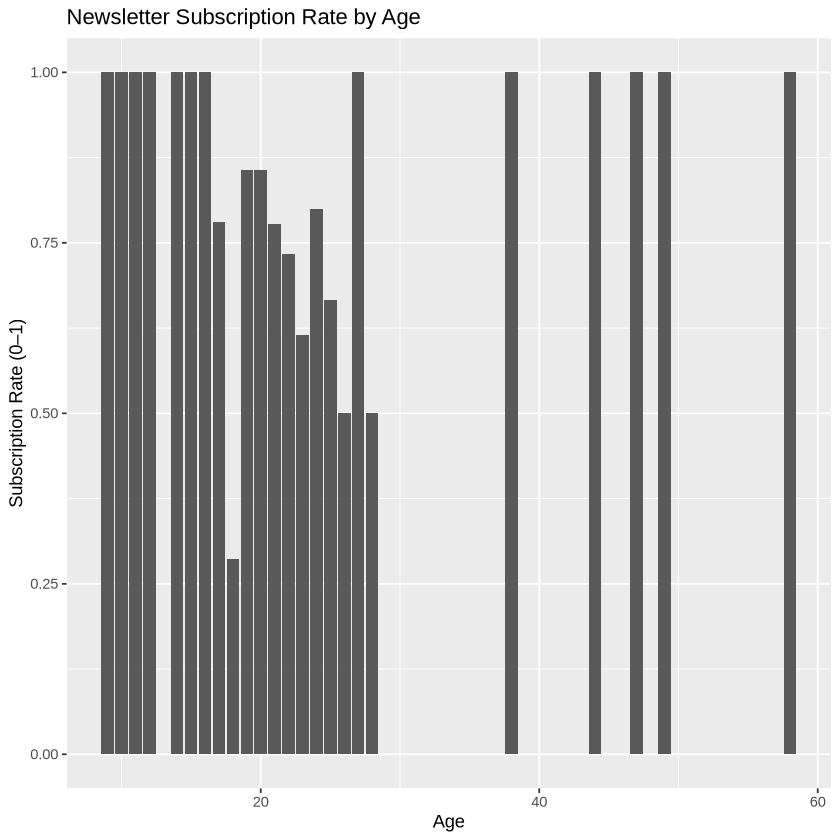

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


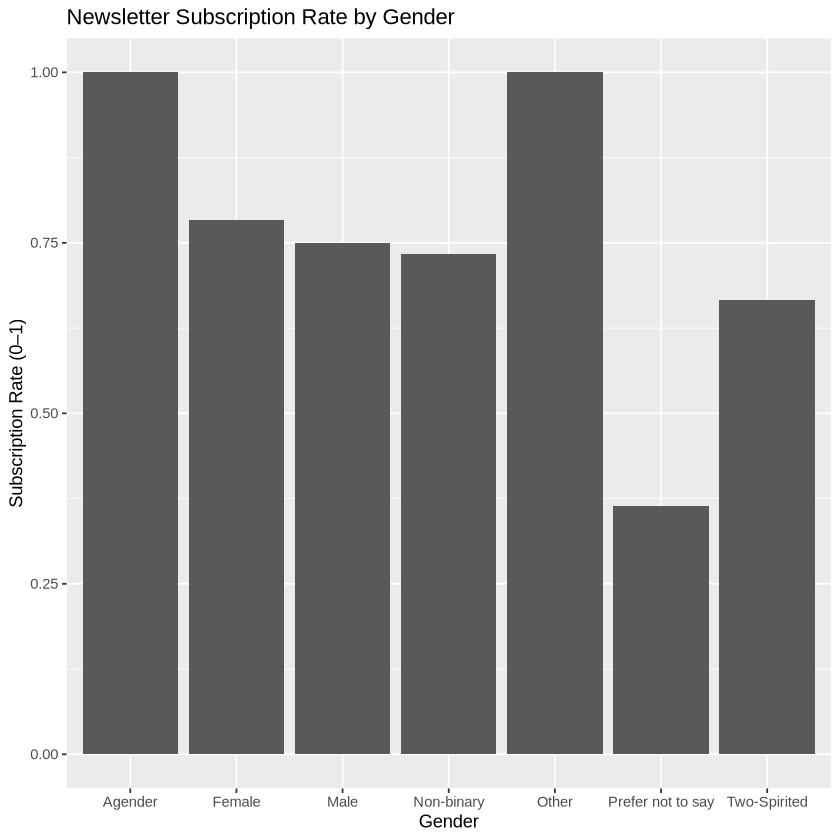

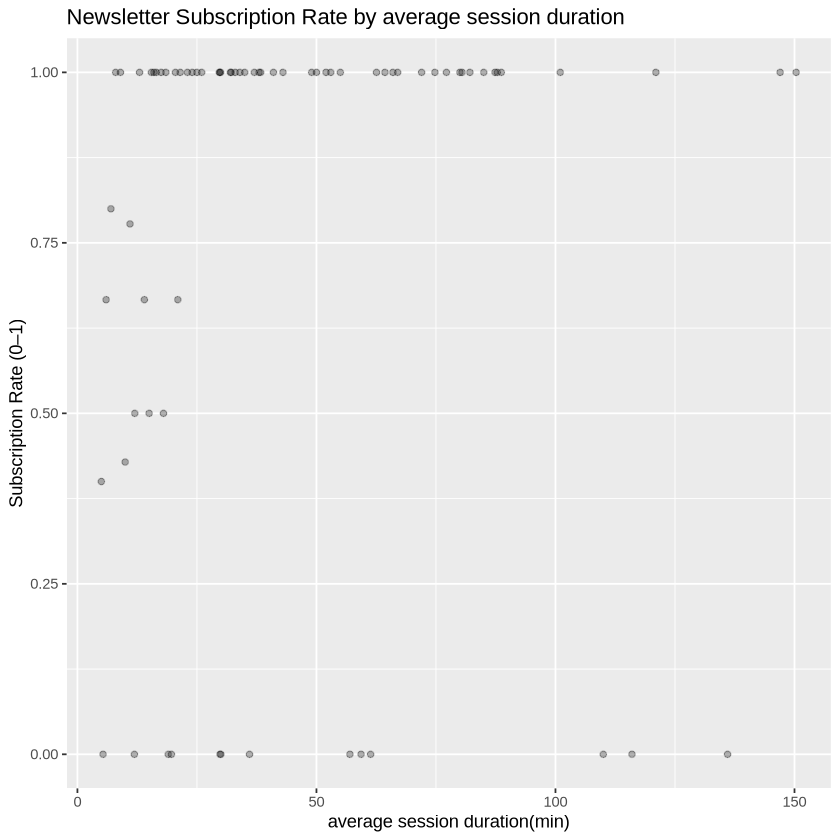

Warning message:
“Removed 73 rows containing missing values or values outside the scale range
(`geom_point()`).”


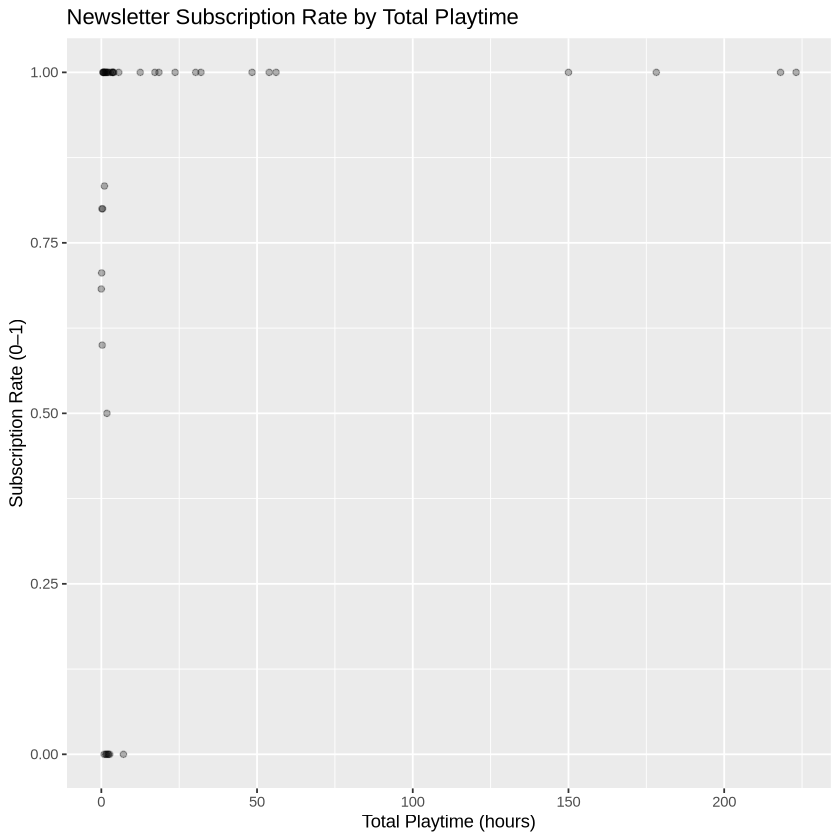

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


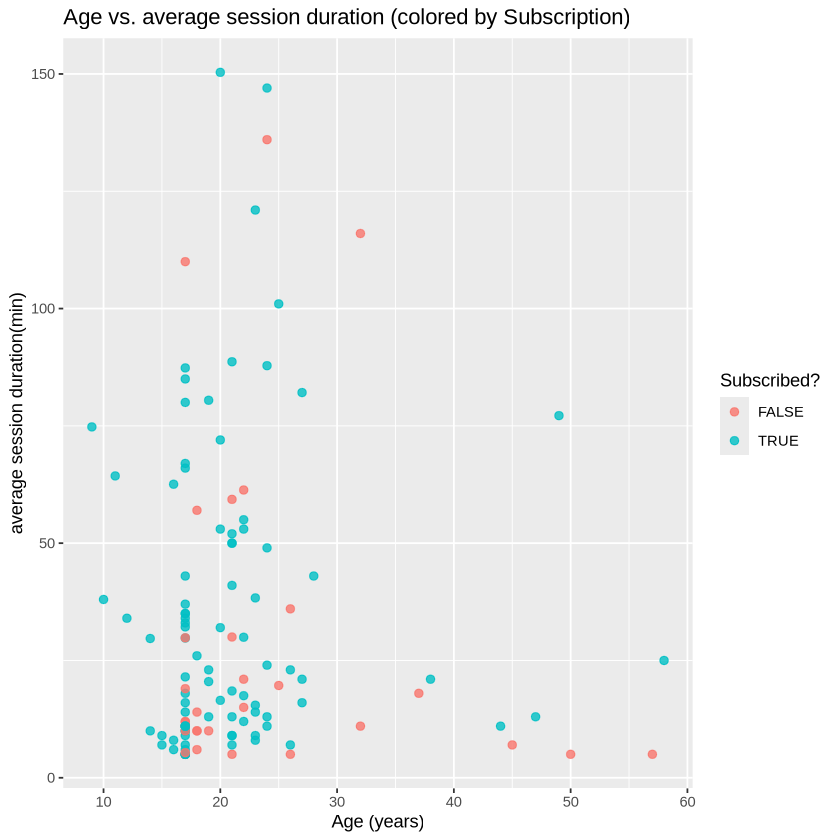

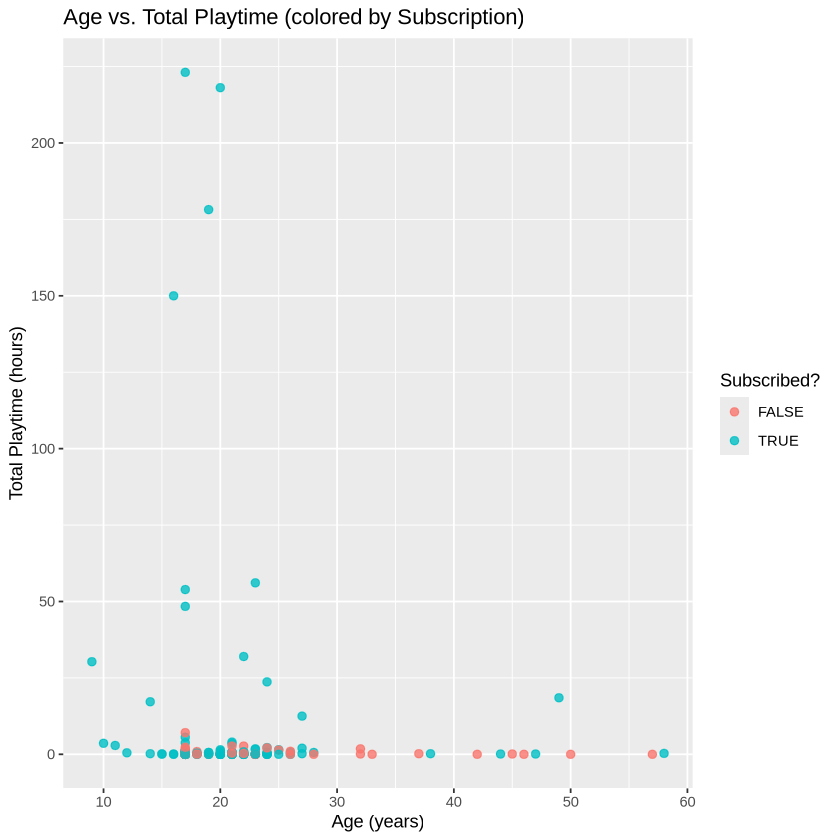

In [46]:
# exploratory visualizations
# Distribution of player age
ggplot(players, aes(x = Age)) +
  geom_histogram() +
  labs(title = "Distribution of Player Ages",
       x = "Age (years)",
       y = "Number of Players")

# Distribution of total playtime
ggplot(players, aes(x = played_hours)) +
  geom_histogram() +
  labs(title = "Distribution of Total Playtime",
       x = "Total Playtime (hours)",
       y = "Number of Players")

# Playtime by Experience
ggplot(players, aes(x = experience, y = played_hours)) +
  geom_point(alpha = 0.3) +
  labs(title = "Playtime by Experience Level",
       x = "Experience Level",
       y = "Played Hours") 

# Bar chart: Subscription rate by Experience
players |>
  group_by(experience) |>
  summarise(sub_rate = mean(subscribe, na.rm = TRUE)) |>
  ggplot(aes(x = experience, y = sub_rate)) +
  geom_col() +
  labs(title = "Newsletter Subscription Rate by Experience Level",
       x = "Experience Level",
       y = "Subscription Rate (0–1)")

# Bar chart: Subscription rate by Age
players |>
  group_by(Age) |>
  summarise(sub_rate = mean(subscribe, na.rm = TRUE)) |>
  ggplot(aes(x = Age, y = sub_rate)) +
  geom_col() +
  labs(title = "Newsletter Subscription Rate by Age",
       x = "Age",
       y = "Subscription Rate (0–1)")

# Bar chart: Subscription rate by gender
players |>
  group_by(gender) |>
  summarise(sub_rate = mean(subscribe, na.rm = TRUE)) |>
  ggplot(aes(x = gender, y = sub_rate)) +
  geom_col() +
  labs(title = "Newsletter Subscription Rate by Gender",
       x = "Gender",
       y = "Subscription Rate (0–1)")

# Scatter plot: Subscription rate by average session duration
players_extended |>
  group_by(avg_session_min) |>
  summarise(sub_rate = mean(subscribe, na.rm = TRUE)) |>
  ggplot(aes(x = avg_session_min, y = sub_rate)) +
  geom_point(alpha = 0.3) +
  labs(title = "Newsletter Subscription Rate by average session duration",
       x = "average session duration(min)",
       y = "Subscription Rate (0–1)")

# Scatter plot: Subscription rate by Playtime
players |>
  group_by(played_hours) |>
  summarise(sub_rate = mean(subscribe, na.rm = TRUE)) |>
  ggplot(aes(x = played_hours, y = sub_rate)) +
  geom_point(alpha = 0.3) +
  labs(title = "Newsletter Subscription Rate by Total Playtime",
       x = "Total Playtime (hours)",
       y = "Subscription Rate (0–1)")

# Scatter plot: Age vs average session duration, colored by Subscription
ggplot(players_extended, aes(x = Age, y = avg_session_min, color = subscribe)) +
  geom_point(size = 2, alpha = 0.8) +
  labs(title = "Age vs. average session duration (colored by Subscription)",
       x = "Age (years)",
       y = "average session duration(min)",
       color = "Subscribed?")


# Scatter plot: Age vs Playtime, colored by Subscription
ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(size = 2, alpha = 0.8) +
  labs(title = "Age vs. Total Playtime (colored by Subscription)",
       x = "Age (years)",
       y = "Total Playtime (hours)",
       color = "Subscribed?")


### Insights from the Visualizations

- **Subscription Rate by Experience:** relationship not clear, but we can tell that beginner and regular level people subscribe more, and veterans subscribe less.
- **Newsletter Subscription Rate by Age** people from 15 to 25 are likely to not subscribe it.
- **Newsletter Subscription Rate by Gender** agender and other gender players subscribe slightly more often, while gender differences remain small overall.
- **Newsletter Subscription Rate by Average play tim/total time** people spending more time playing this game are mo



## (4) Methods and Plan

### Proposed Method
I plan to use a **classification model**, since the goal is to predict whether a player **subscribes to the newsletter (TRUE/FALSE)**.  
The chosen method is **logistic regression**, which estimates the probability of subscription using player characteristics such as **age, gender, experience level, total playtime**, and possibly **session behaviour**.

### Why this method is appropriate
Logistic regression is simple, interpretable, and suitable for binary outcomes.  
It allows us to evaluate how each variable (e.g., experience or playtime) affects the likelihood of subscribing, which aligns with the project’s goal of understanding player behaviour.

### Assumptions
- Observations are independent (each player is treated as one observation).  
- The relationship between predictors and the log-odds of subscription is approximately linear.  
- The predictors are not perfectly correlated (no strong multicollinearity).

### Potential Limitations
- The relationship between predictors and subscription might be nonlinear, which logistic regression may not fully capture.  
- Missing or imbalanced data (e.g., few non-subscribers) could reduce model accuracy.  
- Interaction effects between variables (e.g., experience × playtime) may need to be tested separately.

### Model Comparison and Selection
Model performance will be evaluated using **accuracy** and **cross-validation**.  
I will compare models with different sets of predictors (e.g., demographics only vs. gameplay features) to find which combination predicts subscription most effectively.

### Data Processing Plan
Before modelling, the data will be:
1. Cleaned and encoded (convert categorical variables such as gender and experience to factors).  
2. Split into **training (80%)** and **testing (20%)** sets.  
3. The logistic regression model will be trained on the training data, and its performance tested on the test data.  
4. Cross-validation will be used to ensure that the results are not due to random variation in the split.


### (5) GitHub Repository